In [28]:
import numpy as np
import decentralized as dec

In [49]:
data_baseline = np.load('drone_sim_data.npy')

In [50]:
dataSet = data_baseline
# print(dataSet)
dataSet = np.array(dataSet).T

In [51]:
dataSet.shape

(18, 21)

In [52]:
%matplotlib ipympl

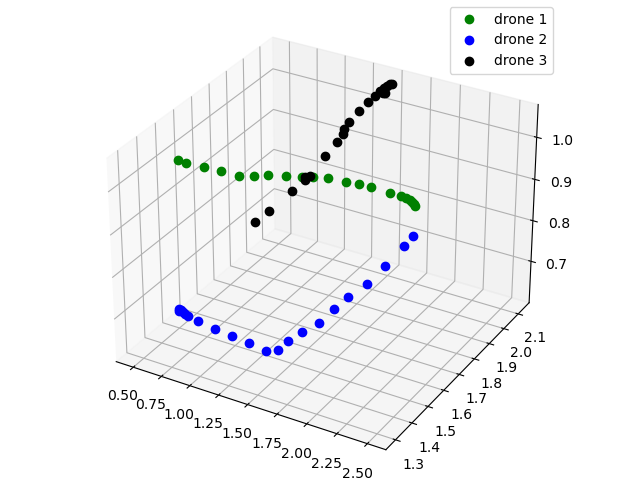

In [74]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot(dataSet[0], dataSet[1], dataSet[2], 'go',label='drone 1')
ax.plot(dataSet[6], dataSet[7], dataSet[8], 'bo',label='drone 2')
ax.plot(dataSet[12], dataSet[13], dataSet[14], 'ko',label='drone 3')
plt.legend(loc='best')
plt.title('Simulated trajectories')
plt.savefig('original_drone.png')


In [78]:
plt.clf()

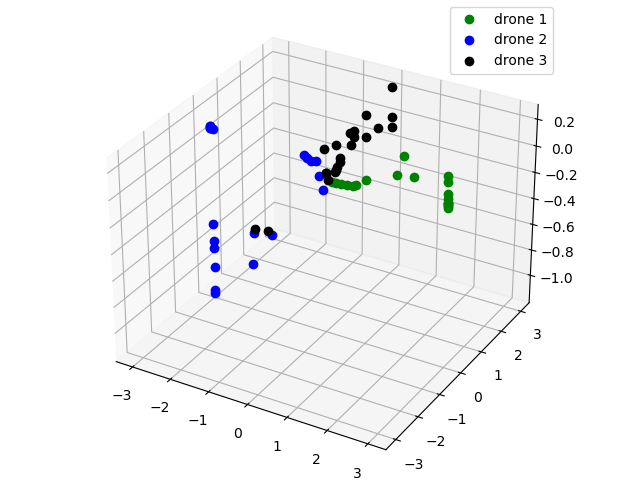

In [79]:
#velocity components:
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot(dataSet[3], dataSet[4], dataSet[5], 'go',label='drone 1')
ax.plot(dataSet[9], dataSet[10], dataSet[11], 'bo',label='drone 2')
ax.plot(dataSet[15], dataSet[16], dataSet[17], 'ko',label='drone 3')
ax.legend()

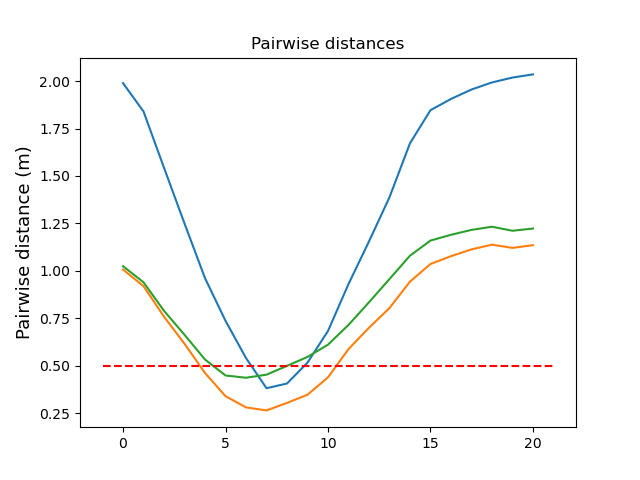

In [80]:
plt.figure()
x_dims = [6,6,6]
radius = 0.5
plt.plot(dec.compute_pairwise_distance(dataSet.T, x_dims, 3))
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
# plt.title('Distance between human and quad over entire horizon')
plt.ylabel('Pairwise distance (m)',fontsize=13)
plt.title('Pairwise distances')
plt.draw()

In [81]:
data_baseline[0]

array([0.515, 1.511, 0.998, 0.   , 0.   , 0.   , 2.504, 1.498, 0.985,
       0.   , 0.   , 0.   , 1.499, 1.302, 1.002, 0.   , 0.   , 0.   ])

In [82]:
data_baseline[-1]

array([ 2.488e+00,  1.521e+00,  1.043e+00,  1.435e-01, -4.069e-04,
       -5.758e-02,  4.935e-01,  1.503e+00,  6.378e-01, -1.002e-01,
        6.119e-05, -1.325e-01,  1.494e+00,  2.069e+00,  1.054e+00,
       -6.119e-05,  3.000e+00, -6.637e-02])